In [5]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.5.1
CUDA available: True


In [10]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.5.1
CUDA available: True


  Using cached xgboost-3.2.0-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.3 MB 5.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.3 MB 3.4 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.3 MB 3.4 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.3 MB 3.5 MB/s eta 0:00:03
   ------------ --------------------------- 3.7/11.3 MB 3.5 MB/s eta 0:00:03
   --------------- ------------------------ 4.5/11.3 MB 3.6 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.3 MB 3.7 MB/s eta

In [11]:
import xgboost as xgb
print(xgb.__version__)

3.2.0


In [2]:
# ============================================================
# CELL 1 (Plan B - Thesis Version)
# Slice-based splitting:
#   Each unique value of the main variable (txgain / mcs / airtime)
#   is treated as ONE independent slice.
#
# Important:
#   If you want to fully follow thesis logic,
#   your training loop (Cell2) must iterate over slices.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 1) Load dataset
# ------------------------------------------------------------
df = pd.read_csv("clean_ul_with_conditions2.csv")

# Target variable
target_col = "pm_power"

# ------------------------------------------------------------
# 2) Define slicing experiments
# ------------------------------------------------------------
EXPERIMENTS = {
    "gain": {
        "slice_col": "txgain",
        "feature_cols": ["selected_mcs", "airtime", "nRBs"]
    },
    "mcs": {
        "slice_col": "selected_mcs", 
        "feature_cols": ["txgain", "airtime", "nRBs"]
    },
    "airtime": {
        "slice_col": "airtime",
        "feature_cols": ["txgain", "selected_mcs", "nRBs"]
    },
}



# ------------------------------------------------------------
# 4) Data cleaning utility
# ------------------------------------------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

# ------------------------------------------------------------
# 5) Slice-based split function
# ------------------------------------------------------------
def split_within_slice(
    d_slice,
    seed=42,
    train_ratio=0.8,
    val_ratio_within_train=0.1
):
    """
    Perform splitting INSIDE one slice.

    Step 1:
        Split into train and test
            train_ratio (default 80%)
            test_ratio  (default 20%)

    Step 2:
        From train part, split validation set
            val_ratio_within_train (default 10% of train)

    Final proportions (default):
        Train ≈ 72%
        Val   ≈ 8%
        Test  ≈ 20%
    """

    # First split: Train / Test
    train_df, test_df = train_test_split(
        d_slice,
        test_size=(1 - train_ratio),
        random_state=seed
    )

    # Second split: Train / Validation
    train_df, val_df = train_test_split(
        train_df,
        test_size=val_ratio_within_train,
        random_state=seed
    )

    return train_df, val_df, test_df



## Model 1 Config

-EPOCHS = 100
-BATCH_SIZE = 64
-LR = 1e-3
-SEED = 42

In [ ]:
# ============================================================
# CELL 2 (Plan B / Thesis slicing) — Model1 Baseline DNN
#
# Thesis slicing logic:
#   For each experiment (gain / mcs / airtime),
#   each unique value of the main variable is treated as ONE slice.
#   We train ONE model per slice.
#
# Inputs:
#   Use condition features only (COND_FEATURES),
#   because the main variable is fixed inside each slice.
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ------------------------------------------------------------
# 1) Dataset wrapper for PyTorch
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------
# 2) Baseline DNN (Model 1)
# ------------------------------------------------------------
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3) Mean Relative Error (percentage)
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ------------------------------------------------------------
# 4) Train & Eval one slice
# ------------------------------------------------------------
def train_eval_model1_slice(
    train_df,
    val_df,
    test_df,
    feature_cols,
    target_col,
    epochs=200,
    batch_size=64,
    lr=1e-3,
    seed=42,
    verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extract arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    # Standardization (fit only on training)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    train_loader = DataLoader(TabularDataset(X_train_s, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val_s,   y_val),   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test),  batch_size=batch_size, shuffle=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BaselineDNN(in_dim=len(feature_cols)).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None

    # Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(xb)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * len(xb)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | Train MSE {train_loss:.6f} | Val MSE {val_loss:.6f}")

    model.load_state_dict(best_state)

    # Test eval
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().reshape(-1)
            y_pred_list.append(pred)
            y_true_list.append(yb.numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse),
        "rmse": float(rmse),
        "mae": float(mae),
        "mre_pct": float(mre),
        "y_true": y_true,
        "y_pred": y_pred,
        "model": model,
        "scaler": scaler,
    }


# ------------------------------------------------------------
# 5) Thesis slicing experiment loop
# ------------------------------------------------------------
results = []
trained_models_m1_slices = {}     # trained_models_m1_slices[exp_name][slice_value] = {model, scaler}
test_outputs_m1_slices = {}       # optional: store predictions per slice

#MIN_SLICE_SIZE = 30  # 太小的 slice 就跳过（你可以调大/调小）

for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]
    feature_cols = exp_cfg["feature_cols"]

    print("\n" + "="*70)
    print(f"Experiment: {exp_name} | slice_col = {slice_col}")
    print("="*70)

    #  # Required columns for this experiment ：slice_col + cond features + target
    cols_needed = [slice_col] + feature_cols + [target_col]

     # Clean dataframe (function defined in Cell 1)
    d = clean_numeric_df(df, cols_needed, target_col)

    # Ensure slice_col is numeric (avoid string grouping bugs)
    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    trained_models_m1_slices.setdefault(exp_name, {})
    test_outputs_m1_slices.setdefault(exp_name, {})

    # Train per slice
    for sval, d_slice in d.groupby(slice_col):
        d_slice = d_slice.copy()


        # Split inside slice (function defined in Cell 1)
        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )

        print(f"\n--- slice {slice_col} = {sval} | sizes: "
              f"train={len(train_df)}, val={len(val_df)}, test={len(test_df)} ---")

        out = train_eval_model1_slice(
            train_df, val_df, test_df,
            feature_cols=exp_cfg["feature_cols"],   
            target_col=target_col,
            epochs=100,
            batch_size=64,
            lr=1e-3,
            seed=42,
            verbose_every=20
        )

        # Save summary metrics
        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model1 (BaselineDNN, slice-wise)",
            "features": ",".join(feature_cols),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        # Save trained objects
        trained_models_m1_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        # Save test predictions
        test_outputs_m1_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m1": out["y_pred"],
        }


# Build final results table
results_df = pd.DataFrame(results)

print("\n=== Results (Model1) ===")
display(results_df)

print("\n=== Sorted by MRE(%) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



Experiment: gain | slice_col = txgain

--- slice txgain = 20 | sizes: train=36, val=5, test=11 ---
Epoch 001 | Train MSE 119.550331 | Val MSE 119.789513
Epoch 020 | Train MSE 104.179794 | Val MSE 100.893456
Epoch 040 | Train MSE 51.603687 | Val MSE 40.941696
Epoch 060 | Train MSE 8.642183 | Val MSE 9.803376
Epoch 080 | Train MSE 4.655833 | Val MSE 5.406807
Epoch 100 | Train MSE 3.271917 | Val MSE 5.813367

--- slice txgain = 21 | sizes: train=43, val=5, test=12 ---
Epoch 001 | Train MSE 120.069565 | Val MSE 117.821678
Epoch 020 | Train MSE 104.711411 | Val MSE 104.357887
Epoch 040 | Train MSE 51.982529 | Val MSE 54.932137
Epoch 060 | Train MSE 11.227999 | Val MSE 3.725917
Epoch 080 | Train MSE 6.094652 | Val MSE 6.549644
Epoch 100 | Train MSE 3.888842 | Val MSE 3.398905

--- slice txgain = 22 | sizes: train=50, val=6, test=14 ---
Epoch 001 | Train MSE 121.600060 | Val MSE 124.147583
Epoch 020 | Train MSE 105.854706 | Val MSE 107.386826
Epoch 040 | Train MSE 51.872612 | Val MSE 52.9596

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",4.189173,2.046747,1.860271,16.870846,36,5,11
1,gain,txgain,21.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",9.377769,3.062314,2.473030,21.628107,43,5,12
2,gain,txgain,22.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",5.490762,2.343238,1.903021,17.056963,50,6,14
3,gain,txgain,23.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",5.438153,2.331985,1.922742,16.967230,57,7,16
4,gain,txgain,24.0,"Model1 (BaselineDNN, slice-wise)","selected_mcs,airtime,nRBs",4.887289,2.210721,1.741613,15.423166,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model1 (BaselineDNN, slice-wise)","txgain,selected_mcs,nRBs",0.116382,0.341148,0.240562,2.033449,367,41,103
71,airtime,airtime,0.7,"Model1 (BaselineDNN, slice-wise)","txgain,selected_mcs,nRBs",0.235939,0.485735,0.295994,2.484939,367,41,103
72,airtime,airtime,0.8,"Model1 (BaselineDNN, slice-wise)","txgain,selected_mcs,nRBs",0.249408,0.499408,0.375275,3.102885,367,41,103
73,airtime,airtime,0.9,"Model1 (BaselineDNN, slice-wise)","txgain,selected_mcs,nRBs",0.150609,0.388083,0.260898,2.100329,367,41,103



=== Sorted by MRE(%) ===
   experiment     slice_col  slice_value                             model  \
74    airtime       airtime          1.0  Model1 (BaselineDNN, slice-wise)   
68    airtime       airtime          0.4  Model1 (BaselineDNN, slice-wise)   
70    airtime       airtime          0.6  Model1 (BaselineDNN, slice-wise)   
64    airtime       airtime          0.0  Model1 (BaselineDNN, slice-wise)   
73    airtime       airtime          0.9  Model1 (BaselineDNN, slice-wise)   
..        ...           ...          ...                               ...   
58        mcs  selected_mcs          9.0  Model1 (BaselineDNN, slice-wise)   
60        mcs  selected_mcs         15.0  Model1 (BaselineDNN, slice-wise)   
61        mcs  selected_mcs         18.0  Model1 (BaselineDNN, slice-wise)   
63        mcs  selected_mcs         23.0  Model1 (BaselineDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model1 (BaselineDNN, slice-wise)   

                    features       MS



## Model 2 Config

EPOCHS = 100
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-2
DROPOUT = 0.3
SEED = 42
VERBOSE_EVERY = 20

In [4]:
# ============================================================
# CELL (Plan B / Thesis slicing) — Model2 RegularizedDNN
#
# Thesis slicing logic:
#   For each experiment (gain / mcs / airtime),
#   each unique value of the main variable is ONE slice.
#   Train ONE Model2 per slice.
#
# Inputs:
#   Use condition features only (COND_FEATURES),
#   since the main variable is fixed inside each slice.
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ---------------------------
# Metric: MRE(%)
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)


# ---------------------------
# Model2: RegularizedDNN
# ---------------------------
class RegularizedDNN(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ---------------------------
# Train + Eval one slice
# ---------------------------
def train_eval_model2_slice(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=400, batch_size=32, lr=1e-3, weight_decay=1e-2,
    patience=20, min_delta=0.0,seed=42, verbose_every=20
):
    
     # -------------------------
    # Reproducibility
    # -------------------------
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # -------------------------
    # Extract arrays
    # -------------------------
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values.astype(float)

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values.astype(float)

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values.astype(float)

    print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

    # -------------------------
    # Standardization (fit on train only)
    # -------------------------
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

     # Convert to tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    # -------------------------
    # Model setup
    # -------------------------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = RegularizedDNN(input_dim=X_train_s.shape[1], dropout=0.3).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    import copy
    best_val = float("inf")
    best_state = None
    no_improve = 0  

    # -------------------------
    # Training loop
    # -------------------------
    for epoch in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(X_train_t.size(0))
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            if idx.numel()<2:
                continue
            xb = X_train_t[idx].to(device)
            yb = y_train_t[idx].to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

         # Compute train/val MSE
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t.to(device))
            val_pred   = model(X_val_t.to(device))
            train_mse  = criterion(train_pred, y_train_t.to(device)).item()
            val_mse    = criterion(val_pred,   y_val_t.to(device)).item()

        # ---- Early stopping (track best by val MSE) ----
        improved = (best_val - val_mse) > min_delta
        if improved:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone()
                        for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stop at epoch {epoch} | best_val={best_val:.6f}")
            break

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

     # Load best checkpoint
    if best_state is not None:
        model.load_state_dict(best_state)

    # -------------------------
    # Test evaluation
    # -------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)

    y_true = y_test_t.numpy().reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": float(mse), "rmse": float(rmse), "mae": float(mae), "mre_pct": float(mre),
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "model": model
    }


# ============================================================
# Main loop: thesis slicing (per slice_value train 1 model)
# ============================================================

results = []
test_outputs_m2_slices = {}
trained_models_m2_slices = {}

MIN_SLICE_SIZE = 5

for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]      
    feature_cols = exp_cfg["feature_cols"]

    
    print("\n" + "="*70)
    print(f"[Thesis] Model2 | Experiment: {exp_name} | slice_col={slice_col}")
    print("="*70)

    cols_needed = [slice_col] + feature_cols+ [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    d[slice_col] = pd.to_numeric(d[slice_col], errors="coerce")
    d = d.dropna(subset=[slice_col]).copy()

    print("Unique slices:", d[slice_col].nunique())

    trained_models_m2_slices.setdefault(exp_name, {})
    test_outputs_m2_slices.setdefault(exp_name, {})

    for sval, d_slice in d.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        # Split inside slice (defined in Cell 1)
        train_df, val_df, test_df = split_within_slice(
            d_slice, seed=42, train_ratio=0.8, val_ratio_within_train=0.1
        )
        if len(train_df) < 10 or len(val_df) < 5 or len(test_df) < 5:
            continue

        print(f"\n--- slice {slice_col}={sval} | sizes: {len(train_df)}/{len(val_df)}/{len(test_df)} ---")

        out = train_eval_model2_slice(
            train_df, val_df, test_df,
            feature_cols = exp_cfg["feature_cols"],
            target_col=target_col,
            epochs=400, batch_size=32, lr=1e-3, weight_decay=1e-2,
            patience =20, min_delta=1e-4,
            seed=42, verbose_every=20
        )

        results.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": float(sval),
            "model": "Model2 (RegularizedDNN, slice-wise)",
            "features": ",".join(feature_cols),
            "MSE": out["mse"],
            "RMSE": out["rmse"],
            "MAE": out["mae"],
            "MRE(%)": out["mre_pct"],
            "n_train": len(train_df),
            "n_val": len(val_df),
            "n_test": len(test_df),
        })

        trained_models_m2_slices[exp_name][float(sval)] = {
            "model": out["model"],
            "scaler": out["scaler"]
        }

        test_outputs_m2_slices[exp_name][float(sval)] = {
            "test_df": test_df.copy(),
            "y_true": out["y_true"],
            "y_pred_m2": out["y_pred"]
        }

results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by experiment + MRE) ===")
print(results_df.sort_values(["experiment", "MRE(%)"]))



[Thesis] Model2 | Experiment: gain | slice_col=txgain
Unique slices: 55

--- slice txgain=20 | sizes: 36/5/11 ---
X_train: (36, 3) X_val: (5, 3) X_test: (11, 3)
Epoch 001 | train MSE 120.111481 | val MSE 121.300919
Epoch 020 | train MSE 110.455826 | val MSE 113.160400
Epoch 040 | train MSE 98.423904 | val MSE 100.780067
Epoch 060 | train MSE 84.775208 | val MSE 88.129295
Epoch 080 | train MSE 69.119484 | val MSE 75.556511
Epoch 100 | train MSE 56.470852 | val MSE 61.726692
Epoch 120 | train MSE 43.242092 | val MSE 47.445087
Epoch 140 | train MSE 33.520672 | val MSE 34.633980
Epoch 160 | train MSE 20.517958 | val MSE 19.896793
Epoch 180 | train MSE 14.869824 | val MSE 12.743681
Epoch 200 | train MSE 9.458107 | val MSE 7.621208
Epoch 220 | train MSE 5.466916 | val MSE 4.757461
Epoch 240 | train MSE 4.018710 | val MSE 3.939072
Epoch 260 | train MSE 2.923361 | val MSE 2.238034
Epoch 280 | train MSE 1.968116 | val MSE 2.103896
Epoch 300 | train MSE 1.516840 | val MSE 1.664199
Epoch 320 | t

,experiment,slice_col,slice_value,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,txgain,20.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",1.298321,1.139439,0.993984,8.969299,36,5,11
1,gain,txgain,21.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",1.556208,1.247481,1.164566,9.957170,43,5,12
2,gain,txgain,22.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.516128,0.718420,0.624384,5.533206,50,6,14
3,gain,txgain,23.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",0.852536,0.923329,0.843415,7.361491,57,7,16
4,gain,txgain,24.0,"Model2 (RegularizedDNN, slice-wise)","selected_mcs,airtime,nRBs",1.431619,1.196503,0.993221,8.883653,58,7,17
...,...,...,...,...,...,...,...,...,...,...,...,...
70,airtime,airtime,0.6,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.418550,0.646955,0.559463,4.813671,367,41,103
71,airtime,airtime,0.7,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.404258,0.635813,0.527014,4.480034,367,41,103
72,airtime,airtime,0.8,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.664503,0.815170,0.681049,5.602550,367,41,103
73,airtime,airtime,0.9,"Model2 (RegularizedDNN, slice-wise)","txgain,selected_mcs,nRBs",0.564788,0.751524,0.639951,5.156038,367,41,103



=== Summary (sorted by experiment + MRE) ===
   experiment     slice_col  slice_value                                model  \
64    airtime       airtime          0.0  Model2 (RegularizedDNN, slice-wise)   
67    airtime       airtime          0.3  Model2 (RegularizedDNN, slice-wise)   
65    airtime       airtime          0.1  Model2 (RegularizedDNN, slice-wise)   
68    airtime       airtime          0.4  Model2 (RegularizedDNN, slice-wise)   
66    airtime       airtime          0.2  Model2 (RegularizedDNN, slice-wise)   
..        ...           ...          ...                                  ...   
58        mcs  selected_mcs          9.0  Model2 (RegularizedDNN, slice-wise)   
57        mcs  selected_mcs          6.0  Model2 (RegularizedDNN, slice-wise)   
63        mcs  selected_mcs         23.0  Model2 (RegularizedDNN, slice-wise)   
59        mcs  selected_mcs         12.0  Model2 (RegularizedDNN, slice-wise)   
62        mcs  selected_mcs         21.0  Model2 (RegularizedDN

## Model 3

In [5]:
# ============================================================
# Model3-B (modified) — Slice-wise
# + feature engineering (thr_per_airtime fixed)
# + Early stopping (DNN)
# + Winsorize + output clipping
# + GPU (torch + xgboost gpu_hist if available)
# + 80/20 split; test used as "validation"
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb

# ---------------------------
# 0) Seed
# ---------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---------------------------
# 1) Metrics
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-3):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return {"MSE": float(mse), "RMSE": rmse, "MAE": float(mae), "MRE(%)": float(mre)}

# ---------------------------
# 2) Feature engineering
# ---------------------------
def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    def has(*cols):
        return all(c in d.columns for c in cols)

    if has("txgain", "airtime"):
        d["txgain_x_airtime"] = d["txgain"] * d["airtime"]
    if has("selected_mcs", "airtime"):
        d["mcs_x_airtime"] = d["selected_mcs"] * d["airtime"]
    if has("mean_snr", "bler"):
        d["snr_per_bler"] = d["mean_snr"].astype(float) / (d["bler"].astype(float) + 1e-6)
    if has("thr", "selected_airtime"):
        # ★ Fix: use selected_airtime (not airtime) to avoid divide-by-zero explosion
        # airtime=0.0 is actually selected_airtime=0.01 (rounded).
        # thr / (airtime=0.0 + 1e-6) = thr * 1,000,000 → max 233,877 (catastrophic!)
        # thr / (selected_airtime=0.01 + 1e-6) → max ~23 (correct)
        d["thr_per_airtime"] = d["thr"].astype(float) / (d["selected_airtime"].astype(float) + 1e-6)
    elif has("thr", "airtime"):
        # fallback if selected_airtime not available
        d["thr_per_airtime"] = d["thr"].astype(float) / (d["airtime"].astype(float).clip(lower=0.01) + 1e-6)
    if has("mean_snr", "rssi_mean"):
        d["snr_minus_rssi"] = d["mean_snr"] - d["rssi_mean"]
    if has("overflows", "underflows", "lates"):
        d["sched_issues"] = d["overflows"].astype(float) + d["underflows"].astype(float) + d["lates"].astype(float)

    return d

# ---------------------------
# 3) Clean numeric
# ---------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d

# ---------------------------
# 3b) Winsorize features
# snr_per_bler has outliers at 99th pct = 33M
# thr_per_airtime outliers now fixed at source, but winsorize as safety net
# ---------------------------
def winsorize_train_test(X_train, X_test, lower_pct=1, upper_pct=99):
    X_train_w = X_train.copy().astype(float)
    X_test_w  = X_test.copy().astype(float)
    for j in range(X_train.shape[1]):
        col_vals = X_train_w[:, j]
        lo = np.percentile(col_vals, lower_pct)
        hi = np.percentile(col_vals, upper_pct)
        if hi > lo:
            X_train_w[:, j] = np.clip(X_train_w[:, j], lo, hi)
            X_test_w[:, j]  = np.clip(X_test_w[:, j],  lo, hi)
    return X_train_w, X_test_w

# ---------------------------
# 4) Dataset
# ---------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------------------------
# 5) DNN
# ---------------------------
class HybridFeatureExtractor(nn.Module):
    def __init__(self, input_dim, emb_dim=32, dropout=0.2):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout / 2),

            nn.Linear(32, emb_dim),
        )
        self.reg_head = nn.Linear(emb_dim, 1)

    def forward(self, x):
        emb = self.feature_net(x)
        out = self.reg_head(emb)
        return out, emb

# ---------------------------
# 6) Train DNN + Early Stopping
# ---------------------------
def train_dnn_and_extract(
    X_train_s, y_train_log,
    X_test_s,  y_test_log,
    input_dim,
    emb_dim=32,
    epochs=200,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    patience=30,
    verbose_every=50,
    seed=42
):
    set_seed(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(
        TabularDataset(X_train_s, y_train_log),
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(
        TabularDataset(X_test_s, y_test_log),
        batch_size=batch_size, shuffle=False
    )

    model = HybridFeatureExtractor(input_dim=input_dim, emb_dim=emb_dim).to(device)
    loss_fn = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_test_loss = float("inf")
    best_state = None
    no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_sum = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred, _ = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_sum += loss.item() * len(xb)
        train_loss = train_sum / len(train_loader.dataset)

        model.eval()
        test_sum = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred, _ = model(xb)
                test_sum += loss_fn(pred, yb).item() * len(xb)
        test_loss = test_sum / len(test_loader.dataset)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"  DNN Epoch {epoch:03d} | train {train_loss:.6f} | test {test_loss:.6f} | no_improve={no_improve}")

        if no_improve >= patience:
            print(f"  Early stop at epoch {epoch} (patience={patience})")
            break

    model.load_state_dict(best_state)

    def extract(X_s, y_log):
        loader = DataLoader(TabularDataset(X_s, y_log), batch_size=batch_size, shuffle=False)
        model.eval()
        preds, embs, ys = [], [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                pred, emb = model(xb)
                preds.append(pred.cpu().numpy().reshape(-1))
                embs.append(emb.cpu().numpy())
                ys.append(yb.numpy().reshape(-1))
        return np.concatenate(preds), np.vstack(embs), np.concatenate(ys)

    dnn_pred_train, emb_train, y_train_log_1d = extract(X_train_s, y_train_log)
    dnn_pred_test,  emb_test,  y_test_log_1d  = extract(X_test_s,  y_test_log)

    return model, dnn_pred_train, emb_train, y_train_log_1d, \
                  dnn_pred_test,  emb_test,  y_test_log_1d

# ---------------------------
# 7) XGBoost on DNN residuals
# ---------------------------
def train_xgb_on_residuals(
    X_train_s, y_train_log, dnn_pred_train_log,
    X_test_s,  y_test_log,  dnn_pred_test_log,
    seed=42,
    params=None,
    num_boost_round=300
):
    residual_train = y_train_log - dnn_pred_train_log
    residual_test  = y_test_log  - dnn_pred_test_log

    if params is None:
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": 0.05,
            "max_depth": 3,
            "min_child_weight": 5,
            "subsample": 0.85,
            "colsample_bytree": 0.9,
            "lambda": 3.0,
            "alpha": 0.5,
            "gamma": 0.1,
            "seed": seed,
            "tree_method": "hist",
            "device": "cuda",
        }

    params = dict(params)
    dtrain = xgb.DMatrix(X_train_s, label=residual_train)
    dtest  = xgb.DMatrix(X_test_s,  label=residual_test)

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "test_residual")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    return booster

# ---------------------------
# 8) Train + eval one slice
# ---------------------------
def train_eval_one_slice(
    d_slice,
    feature_cols,
    target_col,
    seed=42,
    emb_dim=32,
    dnn_epochs=200,
    dnn_patience=30,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    verbose_every=50,
    xgb_params=None,
    num_boost_round=300,
    use_raw_plus_emb=True
):
    set_seed(seed)

    d_train, d_test = train_test_split(d_slice, test_size=0.2, random_state=seed)

    X_train = d_train[feature_cols].values.astype(float)
    X_test  = d_test[feature_cols].values.astype(float)
    y_train = d_train[target_col].values.astype(float)
    y_test  = d_test[target_col].values.astype(float)

    # Winsorize as safety net for any remaining outliers (e.g. snr_per_bler)
    X_train, X_test = winsorize_train_test(X_train, X_test, lower_pct=1, upper_pct=99)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    y_train_log = np.log1p(y_train)
    y_test_log  = np.log1p(y_test)

    # Step1: Train DNN (with early stopping)
    dnn, dnn_pred_train_log, emb_train, y_train_log_1d, \
        dnn_pred_test_log, emb_test, y_test_log_1d = train_dnn_and_extract(
        X_train_s, y_train_log,
        X_test_s,  y_test_log,
        input_dim=len(feature_cols),
        emb_dim=emb_dim,
        epochs=dnn_epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        patience=dnn_patience,
        verbose_every=verbose_every,
        seed=seed
    )

    # Step2: XGBoost on DNN residuals
    booster = train_xgb_on_residuals(
        X_train_s, y_train_log_1d, dnn_pred_train_log,
        X_test_s,  y_test_log_1d,  dnn_pred_test_log,
        seed=seed,
        params=xgb_params,
        num_boost_round=num_boost_round
    )

    # Step3: final prediction = DNN + XGBoost residual correction
    xgb_residual = booster.predict(xgb.DMatrix(X_test_s)).reshape(-1)
    xgb_residual = np.clip(xgb_residual, -0.5, 0.5)   # clip residual in log-space

    y_pred_log = dnn_pred_test_log + xgb_residual

    # Clip to training target range (pm_power in [10.24, 14.12] → log1p in [2.40, 2.71])
    y_log_min = np.log1p(np.min(y_train))
    y_log_max = np.log1p(np.max(y_train))
    y_pred_log = np.clip(y_pred_log, y_log_min - 0.3, y_log_max + 0.3)

    y_pred = np.maximum(np.expm1(y_pred_log), 0.0)
    y_true = np.expm1(y_test_log_1d)

    metrics = compute_metrics(y_true, y_pred)
    return {
        "metrics": metrics,
        "n_train": len(d_train),
        "n_test": len(d_test),
        "d_test": d_test.copy(),
        "dnn": dnn,
        "booster": booster,
        "scaler": scaler,
        "y_true": y_true,
        "y_pred": y_pred
    }

# ============================================================
# 9) Main loop
# ============================================================

df_fe = add_feature_engineering(df)

EXPERIMENTS = {
    "gain":    {"slice_col": "txgain",       "feature_cols": ["selected_mcs", "airtime", "nRBs"]},
    "mcs":     {"slice_col": "selected_mcs", "feature_cols": ["txgain", "airtime", "nRBs"]},
    "airtime": {"slice_col": "airtime",      "feature_cols": ["txgain", "selected_mcs", "nRBs"]},
}

ENGINEERED = [
    "txgain_x_airtime",
    "mcs_x_airtime",
    "snr_per_bler",
    "thr_per_airtime",
    "snr_minus_rssi",
    "sched_issues"
]

INCLUDE_SLICE_IN_INPUT = False
MIN_SLICE_SIZE = 30
SEED = 42

all_rows = []
test_outputs_m3B = {}
trained_models_m3B = {}

for exp_name, exp_cfg in EXPERIMENTS.items():
    slice_col    = exp_cfg["slice_col"]
    feature_cols = exp_cfg["feature_cols"].copy()

    if slice_col not in df_fe.columns:
        print(f"[Skip] {exp_name}: slice_col '{slice_col}' not in df columns")
        continue

    feature_cols += [c for c in ENGINEERED if c in df_fe.columns]

    if INCLUDE_SLICE_IN_INPUT and slice_col not in feature_cols:
        feature_cols = [slice_col] + feature_cols

    cols_needed = feature_cols + [slice_col, target_col]
    d0 = clean_numeric_df(df_fe, cols_needed, target_col)

    print("\n=====================================================")
    print(f"[Model3-B Residual] Experiment: {exp_name} | slice_col={slice_col}")
    print(f"Input features: {feature_cols}")
    print("=====================================================")

    for sval, d_slice in d0.groupby(slice_col):
        if len(d_slice) < MIN_SLICE_SIZE:
            continue

        print(f"\n--- slice {slice_col}={sval} | n={len(d_slice)} ---")

        out = train_eval_one_slice(
            d_slice=d_slice,
            feature_cols=feature_cols,
            target_col=target_col,
            seed=SEED,
            emb_dim=32,
            dnn_epochs=200,
            dnn_patience=30,
            batch_size=32,
            lr=1e-3,
            weight_decay=1e-4,
            verbose_every=50,
            xgb_params=None,
            num_boost_round=300,
        )

        m = out["metrics"]
        all_rows.append({
            "experiment": exp_name,
            "slice_col": slice_col,
            "slice_value": sval,
            "features": ",".join(feature_cols),
            "MSE": m["MSE"],
            "RMSE": m["RMSE"],
            "MAE": m["MAE"],
            "MRE(%)": m["MRE(%)"],
            "n_train": out["n_train"],
            "n_test": out["n_test"],
            "n_slice": len(d_slice),
        })

        test_outputs_m3B.setdefault(exp_name, {})
        test_outputs_m3B[exp_name][sval] = {
            "test_df": out["d_test"].copy(),
            "y_true": out["y_true"],
            "y_pred_m3B": out["y_pred"]
        }

        trained_models_m3B.setdefault(exp_name, {})
        trained_models_m3B[exp_name][sval] = {
            "dnn": out["dnn"],
            "booster": out["booster"],
            "scaler": out["scaler"],
            "feature_cols": feature_cols
        }

results_slices_df = pd.DataFrame(all_rows)
print("\n===== Model3 Results =====")
display(results_slices_df.sort_values(["experiment", "slice_value"]))



[Model3-B Residual] Experiment: gain | slice_col=txgain
Input features: ['selected_mcs', 'airtime', 'nRBs', 'txgain_x_airtime', 'mcs_x_airtime', 'snr_per_bler', 'thr_per_airtime', 'snr_minus_rssi', 'sched_issues']

--- slice txgain=20 | n=52 ---
  DNN Epoch 001 | train 1.277957 | test 1.719406 | no_improve=0
  DNN Epoch 050 | train 0.090294 | test 0.118019 | no_improve=2
  DNN Epoch 100 | train 0.032805 | test 0.065036 | no_improve=14
  Early stop at epoch 116 (patience=30)

--- slice txgain=21 | n=60 ---
  DNN Epoch 001 | train 1.094949 | test 1.797581 | no_improve=0
  DNN Epoch 050 | train 0.051773 | test 0.168628 | no_improve=5
  DNN Epoch 100 | train 0.047812 | test 0.059023 | no_improve=9
  DNN Epoch 150 | train 0.021998 | test 0.057120 | no_improve=26
  Early stop at epoch 154 (patience=30)

--- slice txgain=22 | n=70 ---
  DNN Epoch 001 | train 0.944422 | test 1.753704 | no_improve=0
  DNN Epoch 050 | train 0.052068 | test 0.176898 | no_improve=4
  DNN Epoch 100 | train 0.03132

,experiment,slice_col,slice_value,features,MSE,RMSE,MAE,MRE(%),n_train,n_test,n_slice
64,airtime,airtime,0.0,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.119598,0.345830,0.158206,1.430063,427,107,534
65,airtime,airtime,0.1,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.107285,0.327543,0.223054,2.033549,429,108,537
66,airtime,airtime,0.2,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.083160,0.288376,0.231782,2.138584,432,108,540
67,airtime,airtime,0.3,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.088475,0.297447,0.231098,2.088189,435,109,544
68,airtime,airtime,0.4,"txgain,selected_mcs,nRBs,txgain_x_airtime,mcs_...",0.105766,0.325217,0.231250,2.008988,412,103,515
...,...,...,...,...,...,...,...,...,...,...,...
59,mcs,selected_mcs,12.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.062943,0.250884,0.205212,1.809484,468,117,585
60,mcs,selected_mcs,15.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.097201,0.311770,0.216706,1.868082,450,113,563
61,mcs,selected_mcs,18.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.132226,0.363629,0.277358,2.370778,438,110,548
62,mcs,selected_mcs,21.0,"txgain,airtime,nRBs,txgain_x_airtime,mcs_x_air...",0.134808,0.367162,0.285487,2.406654,431,108,539


In [6]:
print("Model1 airtime keys:", sorted(test_outputs_m1_slices["airtime"].keys()))
print("Model2 airtime keys:", sorted(test_outputs_m2_slices["airtime"].keys()))
print("Model3 airtime keys:", sorted(test_outputs_m3B["airtime"].keys()))

Model1 airtime keys: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Model2 airtime keys: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Model3 airtime keys: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B)


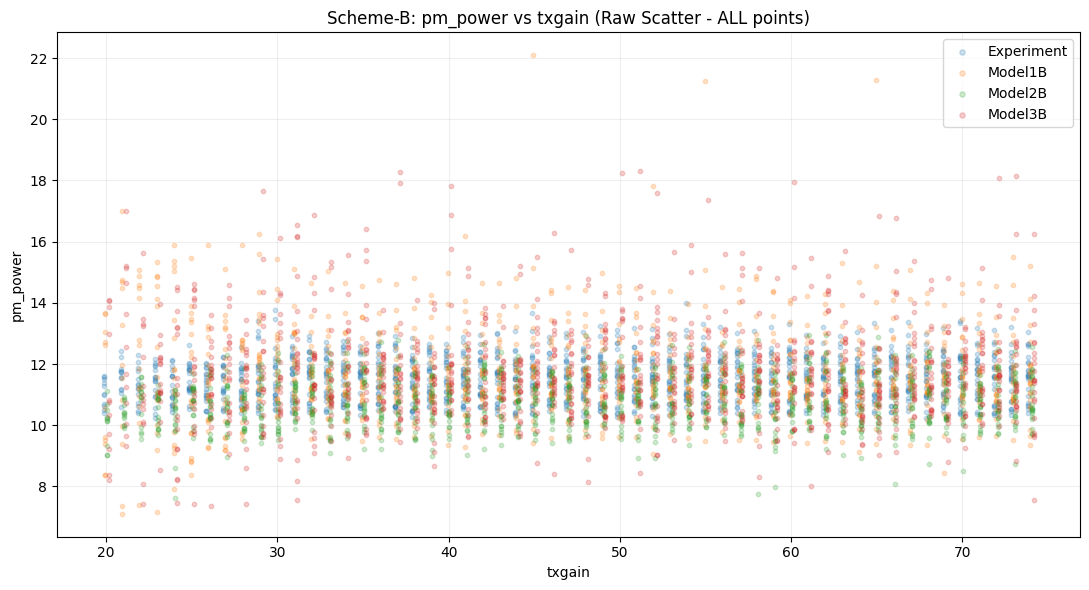

Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)
Total points plotted (raw): 1158
[Model1B] MSE=2.1768 RMSE=1.4754 MAE=1.0798 MRE=9.41%
[Model2B] MSE=0.8698 RMSE=0.9326 MAE=0.7970 MRE=6.88%
[Model3B] MSE=2.4437 RMSE=1.5632 MAE=1.1096 MRE=9.66%


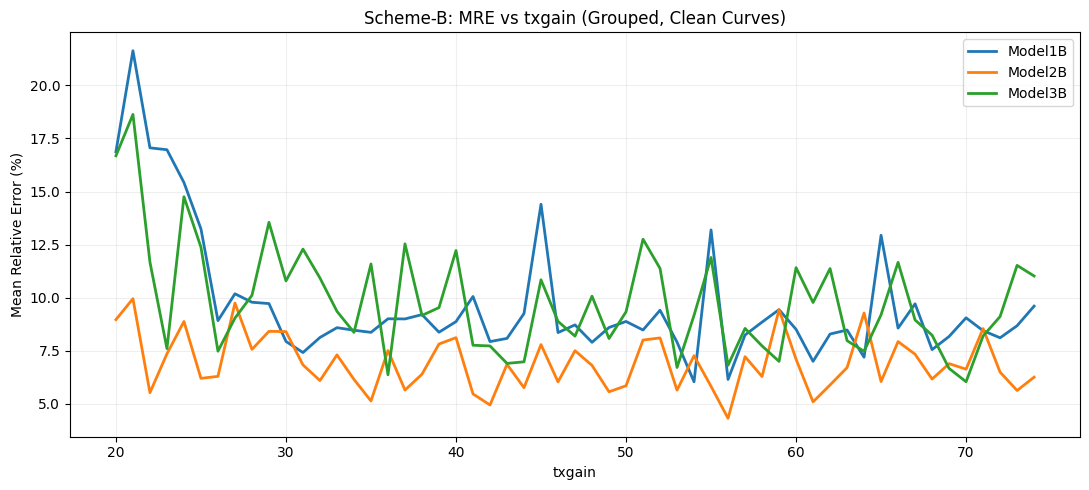

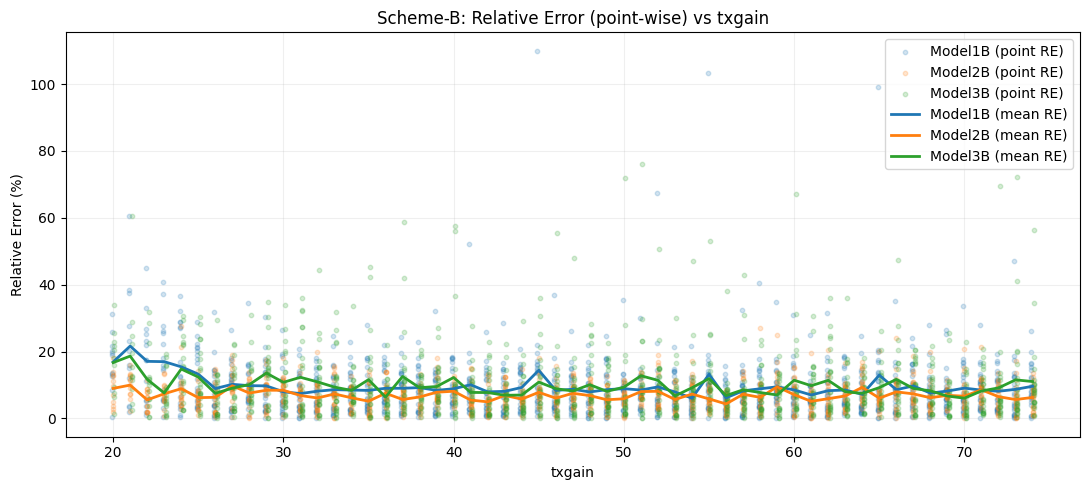

Scheme-B: Relative Error (point-wise) vs txgain
Total points: 1158
Point-RE mean:   M1=9.41% | M2=6.88% | M3=9.66%
Point-RE median: M1=7.57% | M2=6.65% | M3=7.02%


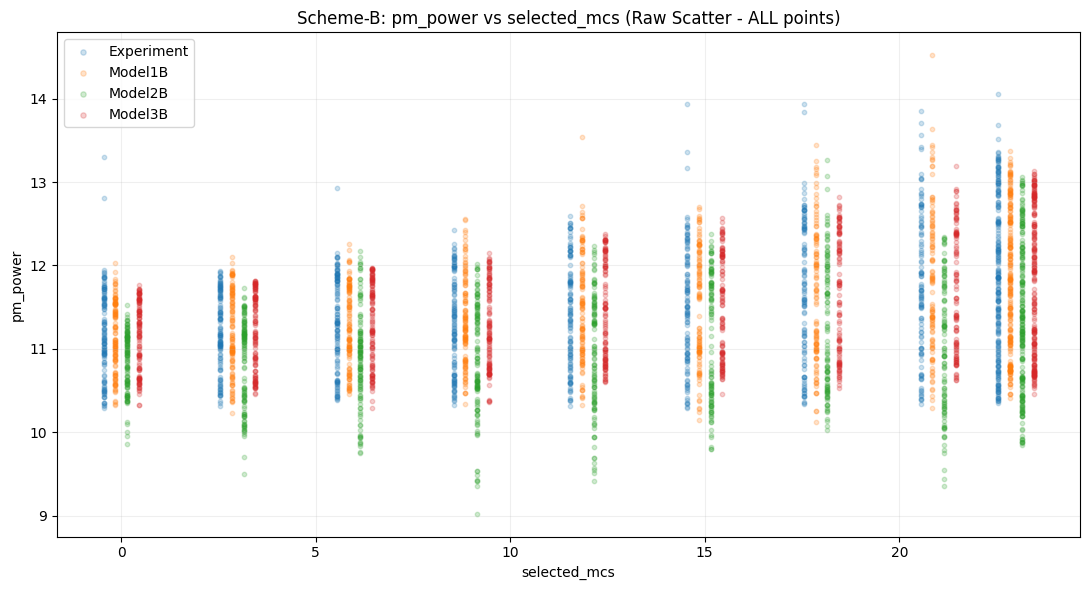

Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)
Total points plotted (raw): 1156
[Model1B] MSE=0.1124 RMSE=0.3353 MAE=0.2454 MRE=2.12%
[Model2B] MSE=0.3789 RMSE=0.6156 MAE=0.4885 MRE=4.20%
[Model3B] MSE=0.0986 RMSE=0.3140 MAE=0.2299 MRE=1.98%


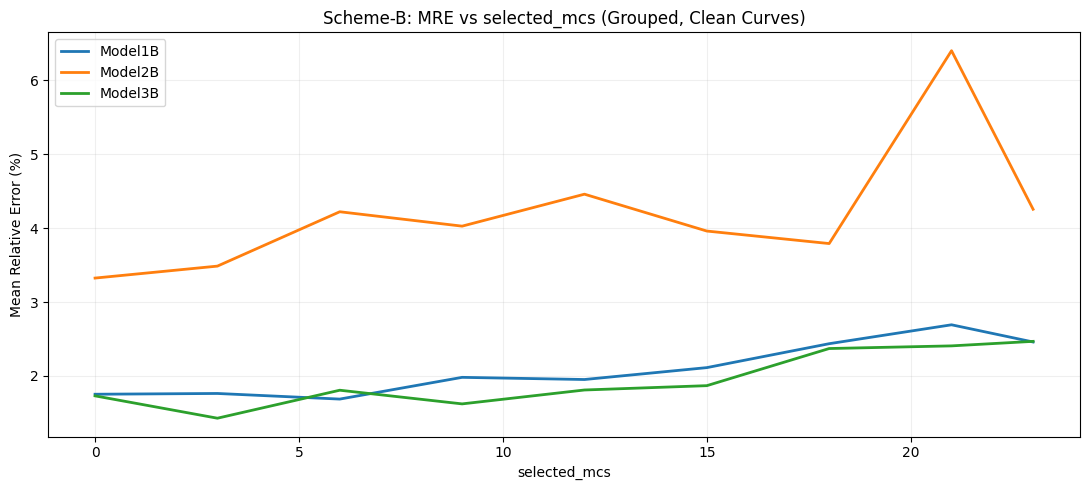

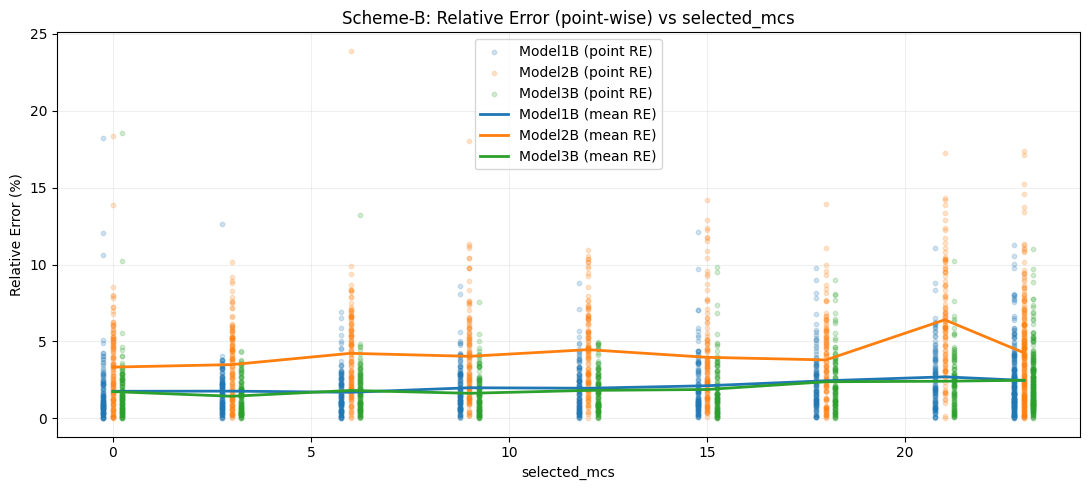

Scheme-B: Relative Error (point-wise) vs selected_mcs
Total points: 1156
Point-RE mean:   M1=2.12% | M2=4.20% | M3=1.98%
Point-RE median: M1=1.64% | M2=3.76% | M3=1.59%


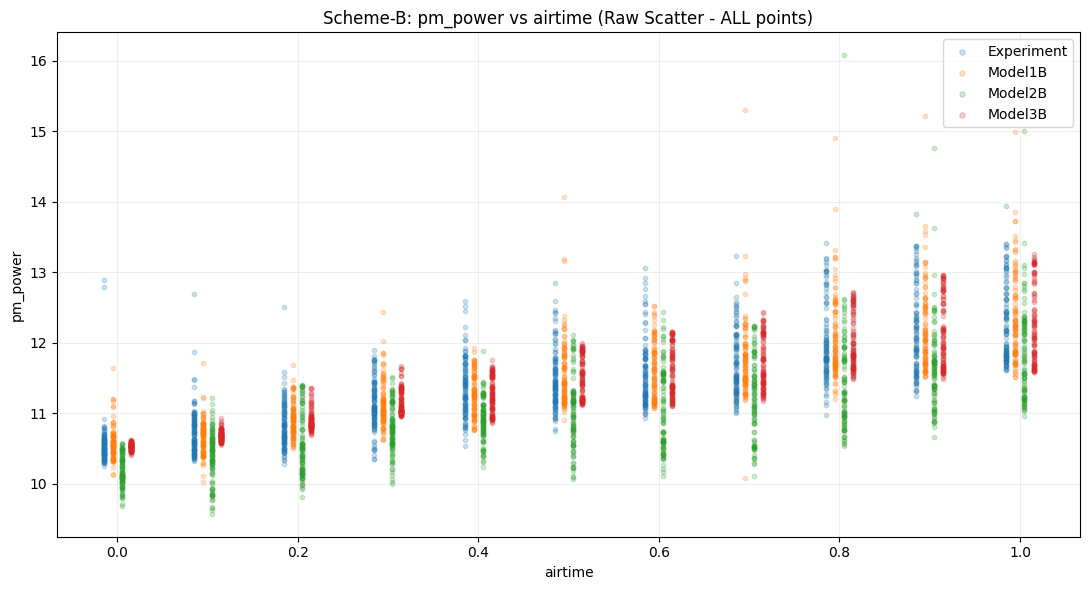

Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)
Total points plotted (raw): 1159
[Model1B] MSE=0.1637 RMSE=0.4046 MAE=0.2710 MRE=2.34%
[Model2B] MSE=0.4153 RMSE=0.6444 MAE=0.5235 MRE=4.50%
[Model3B] MSE=0.0973 RMSE=0.3119 MAE=0.2206 MRE=1.91%


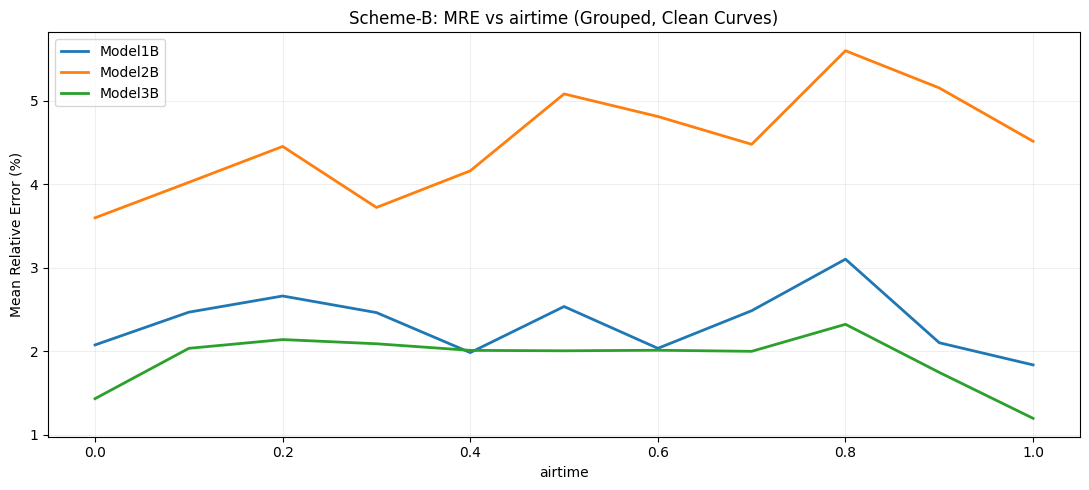

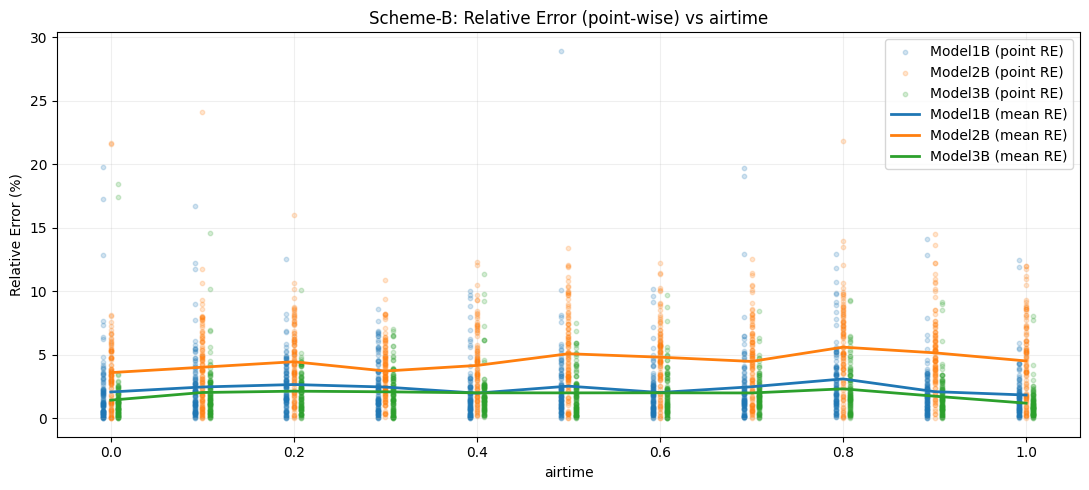

Scheme-B: Relative Error (point-wise) vs airtime
Total points: 1159
Point-RE mean:   M1=2.34% | M2=4.50% | M3=1.91%
Point-RE median: M1=1.70% | M2=4.24% | M3=1.47%


In [8]:
# ============================================================
# SCATTER (ALL POINTS) + CLEAN MRE CURVES — Scheme B
# Compare Model1B vs Model2B vs Model3B
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ------------------------------------------------------------
# 0) Metrics
# ------------------------------------------------------------
def relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return (np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100

def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return mse, rmse, mae, mre


# ------------------------------------------------------------
# 1) Helper: robustly fetch prediction key 
# ------------------------------------------------------------
def _pick_pred_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    raise KeyError(f"Cannot find prediction key in dict. Tried: {candidates}. Keys={list(d.keys())}")

def _as_float(x):
    try:
        return float(x)
    except Exception:
        return float(np.asarray(x).item())


# ------------------------------------------------------------
# 2) Build unified raw DF for scheme B (concatenate all slices)
# ------------------------------------------------------------
def build_raw_test_dataframe_B(exp_name, xcol, test_outputs_m1B, test_outputs_m2B, test_outputs_m3B):
    """
    Scheme B: each slice_value has its own trained model + its own test set.
    We concatenate ALL slice test points into one big df_plot for scatter/MRE curves.
    """

    d_m1 = test_outputs_m1B[exp_name]
    d_m2 = test_outputs_m2B[exp_name]
    d_m3 = test_outputs_m3B[exp_name]

    def norm_map(d):
        mp = {}
        for k, v in d.items():
            mp[_as_float(k)] = v
        return mp

    m1 = norm_map(d_m1)
    m2 = norm_map(d_m2)
    m3 = norm_map(d_m3)

    common_keys = sorted(set(m1.keys()) & set(m2.keys()) & set(m3.keys()))
    if len(common_keys) == 0:
        raise ValueError(f"No common slice keys for exp={exp_name}. "
                         f"m1={len(m1)}, m2={len(m2)}, m3={len(m3)}")

    rows = []

    for s in common_keys:

        d1 = m1[s]
        d2 = m2[s]
        d3 = m3[s]

        
        k1 = _pick_pred_key(d1, ["y_pred_m1B", "y_pred_m1", "y_pred"])
        k2 = _pick_pred_key(d2, ["y_pred_m2B", "y_pred_m2", "y_pred"])
        k3 = _pick_pred_key(d3, ["y_pred_m3B", "y_pred_m3", "y_pred"])

        y_true = np.asarray(d1["y_true"]).reshape(-1)
        y_m1   = np.asarray(d1[k1]).reshape(-1)
        y_m2   = np.asarray(d2[k2]).reshape(-1)
        y_m3   = np.asarray(d3[k3]).reshape(-1)

        
        n = min(len(y_true), len(y_m1), len(y_m2), len(y_m3))
        if n == 0:
            continue
        
        y_true, y_m1, y_m2, y_m3 = y_true[:n], y_m1[:n], y_m2[:n], y_m3[:n]
        x = np.full(n, s, dtype=float)

        rows.append(pd.DataFrame({
            xcol: x,
            "y_true": y_true,
            "y_pred_m1": y_m1,
            "y_pred_m2": y_m2,
            "y_pred_m3": y_m3,
            "slice_value": s
        }))

    if len(rows) == 0:
        raise ValueError(f"Rows empty for exp={exp_name}. Possibly all slices had n==0 after alignment.")

    df_plot = pd.concat(rows, ignore_index=True)

    df_plot = df_plot.dropna(subset=[xcol, "y_true"]).copy()
    return df_plot


# ------------------------------------------------------------
# 3) Full raw scatter (ALL points) with horizontal offsets
# ------------------------------------------------------------
def plot_raw_scatter_with_offset_full(
    df_plot,
    xcol,
    title,
    offset_fraction=0.03,
    point_size=10,
    alpha=0.25,
    figsize=(11, 6)
):
    d = df_plot.dropna().copy()
    d = d.sort_values(xcol)

    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    unique_ratio = len(x_unique) / max(len(x), 1)

    # scheme B is usually discrete slices, but keep auto logic
    if len(x_unique) <= 60 or unique_ratio < 0.02:
        if len(x_unique) > 1:
            steps = np.diff(np.sort(x_unique))
            steps = steps[steps > 0]
            step = float(np.median(steps)) if len(steps) else 1.0
        else:
            step = 1.0
        dx = 0.1 * step
    else:
        x_min, x_max = float(np.min(x)), float(np.max(x))
        x_range = max(x_max - x_min, 1e-9)
        dx = offset_fraction * x_range

    offsets = {"exp": -1.5 * dx, "m1": -0.5 * dx, "m2": 0.5 * dx, "m3": 1.5 * dx}

    # metrics
    m1 = compute_metrics(d["y_true"], d["y_pred_m1"])
    m2 = compute_metrics(d["y_true"], d["y_pred_m2"])
    m3 = compute_metrics(d["y_true"], d["y_pred_m3"])

    plt.figure(figsize=figsize)
    plt.scatter(x + offsets["exp"], d["y_true"],    s=point_size, alpha=alpha, label="Experiment")
    plt.scatter(x + offsets["m1"],  d["y_pred_m1"], s=point_size, alpha=alpha, label="Model1B")
    plt.scatter(x + offsets["m2"],  d["y_pred_m2"], s=point_size, alpha=alpha, label="Model2B")
    plt.scatter(x + offsets["m3"],  d["y_pred_m3"], s=point_size, alpha=alpha, label="Model3B")

    plt.xlabel(xcol)
    plt.ylabel("pm_power")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend(markerscale=1.2, frameon=True)
    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print(title)
    print(f"Total points plotted (raw): {len(d)}")
    print(f"[Model1B] MSE={m1[0]:.4f} RMSE={m1[1]:.4f} MAE={m1[2]:.4f} MRE={m1[3]:.2f}%")
    print(f"[Model2B] MSE={m2[0]:.4f} RMSE={m2[1]:.4f} MAE={m2[2]:.4f} MRE={m2[3]:.2f}%")
    print(f"[Model3B] MSE={m3[0]:.4f} RMSE={m3[1]:.4f} MAE={m3[2]:.4f} MRE={m3[3]:.2f}%")
    print("=" * 60)


# ------------------------------------------------------------
# 4) Clean MRE curves (grouped by x)
# ------------------------------------------------------------



def group_mean_mre_curve(df_plot, xcol, pred_col, eps=1e-9, min_count=1):
    d = df_plot[[xcol, "y_true", pred_col]].dropna().copy()
    d["rel_err"] = (np.abs(d["y_true"] - d[pred_col]) / (np.abs(d["y_true"]) + eps)) * 100

    g = d.groupby(xcol).agg(
        mre=("rel_err", "mean"),
        n=("rel_err", "size")
    ).reset_index()

    g = g[g["n"] >= min_count].copy()
    g = g.sort_values(xcol)
    return g


def plot_pointwise_re_scatter(
    df_plot,
    xcol,
    title,
    eps=1e-9,
    point_size=10,
    alpha=0.20,
    figsize=(11, 5),
    show_group_curve=True,
    how="mean",     # "mean" or "median"
    min_count=1
):
    """
    Point-wise Relative Error scatter:
      RE_i = |y_true_i - y_pred_i| / (|y_true_i| + eps) * 100

    show_group_curve=True will overlay grouped mean/median RE vs xcol.
    """

    d = df_plot[[xcol, "y_true", "y_pred_m1", "y_pred_m2", "y_pred_m3"]].dropna().copy()
    d = d.sort_values(xcol)

    # point-wise RE for each model
    d["re_m1"] = (np.abs(d["y_true"] - d["y_pred_m1"]) / (np.abs(d["y_true"]) + eps)) * 100
    d["re_m2"] = (np.abs(d["y_true"] - d["y_pred_m2"]) / (np.abs(d["y_true"]) + eps)) * 100
    d["re_m3"] = (np.abs(d["y_true"] - d["y_pred_m3"]) / (np.abs(d["y_true"]) + eps)) * 100

    # horizontal offsets (avoid overlap when x is discrete slices)
    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    if len(x_unique) > 1:
        steps = np.diff(np.sort(x_unique))
        steps = steps[steps > 0]
        step = float(np.median(steps)) if len(steps) else 1.0
    else:
        step = 1.0
    dx = 0.08 * step
    offsets = {"m1": -dx, "m2": 0.0, "m3": dx}

    plt.figure(figsize=figsize)
    plt.scatter(x + offsets["m1"], d["re_m1"], s=point_size, alpha=alpha, label="Model1B (point RE)")
    plt.scatter(x + offsets["m2"], d["re_m2"], s=point_size, alpha=alpha, label="Model2B (point RE)")
    plt.scatter(x + offsets["m3"], d["re_m3"], s=point_size, alpha=alpha, label="Model3B (point RE)")

    # optional grouped curve overlay
    if show_group_curve:
        if how not in ["mean", "median"]:
            raise ValueError("how must be 'mean' or 'median'")

        def _group_curve(re_col):
            g = d.groupby(xcol).agg(
                re=(re_col, how),
                n=(re_col, "size")
            ).reset_index()
            g = g[g["n"] >= min_count].sort_values(xcol)
            return g

        g1 = _group_curve("re_m1")
        g2 = _group_curve("re_m2")
        g3 = _group_curve("re_m3")

        plt.plot(g1[xcol], g1["re"], linewidth=2, label=f"Model1B ({how} RE)")
        plt.plot(g2[xcol], g2["re"], linewidth=2, label=f"Model2B ({how} RE)")
        plt.plot(g3[xcol], g3["re"], linewidth=2, label=f"Model3B ({how} RE)")

    plt.xlabel(xcol)
    plt.ylabel("Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # quick stats
    print("=" * 60)
    print(title)
    print(f"Total points: {len(d)}")
    print(f"Point-RE mean:   M1={d['re_m1'].mean():.2f}% | M2={d['re_m2'].mean():.2f}% | M3={d['re_m3'].mean():.2f}%")
    print(f"Point-RE median: M1={d['re_m1'].median():.2f}% | M2={d['re_m2'].median():.2f}% | M3={d['re_m3'].median():.2f}%")
    print("=" * 60)



def plot_mre_curves_clean(df_plot, xcol, title, min_count=1, figsize=(11, 5)):
    g1 = group_mean_mre_curve(df_plot, xcol, "y_pred_m1", min_count=min_count)
    g2 = group_mean_mre_curve(df_plot, xcol, "y_pred_m2", min_count=min_count)
    g3 = group_mean_mre_curve(df_plot, xcol, "y_pred_m3", min_count=min_count)

    plt.figure(figsize=figsize)
    plt.plot(g1[xcol], g1["mre"], label="Model1B", linewidth=2)
    plt.plot(g2[xcol], g2["mre"], label="Model2B", linewidth=2)
    plt.plot(g3[xcol], g3["mre"], label="Model3B", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel("Mean Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 5) Run plots for gain / mcs / airtime (scheme B)
# ------------------------------------------------------------
# You MUST already have:
#   test_outputs_m1B, test_outputs_m2B, test_outputs_m3B
# in memory.

PLOT_CONFIG = {
    "gain":    ("txgain",        "Scheme-B: pm_power vs txgain (Raw Scatter - ALL points)"),
    "mcs":     ("selected_mcs",  "Scheme-B: pm_power vs selected_mcs (Raw Scatter - ALL points)"),
    "airtime": ("airtime",       "Scheme-B: pm_power vs airtime (Raw Scatter - ALL points)"),
}

import inspect
print(inspect.signature(build_raw_test_dataframe_B))


for exp_name, (xcol, title) in PLOT_CONFIG.items():
    df_plot = build_raw_test_dataframe_B(
        exp_name=exp_name,
        xcol=xcol,
        test_outputs_m1B=test_outputs_m1_slices,
        test_outputs_m2B=test_outputs_m2_slices,
        test_outputs_m3B=test_outputs_m3B
    )

    plot_raw_scatter_with_offset_full(
        df_plot=df_plot,
        xcol=xcol,
        title=title,
        offset_fraction=0.02,
        point_size=10,
        alpha=0.22,
        figsize=(11, 6)
    )

    plot_mre_curves_clean(
        df_plot=df_plot,
        xcol=xcol,
        title=f"Scheme-B: MRE vs {xcol} (Grouped, Clean Curves)",
        min_count=1
    )

    plot_pointwise_re_scatter(
        df_plot=df_plot,
        xcol=xcol,
        title=f"Scheme-B: Relative Error (point-wise) vs {xcol}",
        point_size=10,
        alpha=0.20,
        figsize=(11, 5),
        show_group_curve=True,  
        how="mean",           
        min_count=1
    )

    